In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

import os
import sys
import numpy as np
from glob import glob
import dataflow
import numpy as np
import zstandard as zstd
import msgpack
import msgpack_numpy
msgpack_numpy.patch()

from tqdm.notebook import trange, tqdm
from rbfNet import *

from plotting import *
plt.style.use('dark_background')
# plt.style.use('default')
from tqdm.notebook import trange, tqdm
decompressor = zstd.ZstdDecompressor()
from rbfNet import *
from tqdm.notebook import trange, tqdm

2023-03-06 10:41:12.173361: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/winchenbach/anaconda3/envs/DeepLagrangianFluids/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
def getGroundTruth(fileName, frameIndex):
    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
    return inputData['fluidPosition'].to(device), inputData['fluidVelocity'].to(device)

extension = '.hdf5'

basePath = os.path.expanduser('~/dev/datasets/WBCSPH2Dc')
trainFiles = glob(os.path.join(os.path.join(basePath, 'train'), '*' + extension))
validFiles = glob(os.path.join(os.path.join(basePath, 'valid'), '*' + extension))
testFiles = glob(os.path.join(os.path.join(basePath, 'test'), '*' + extension))

# print(trainFiles)
# print(validFiles)
# print(testFiles)

simulationFiles = sorted(trainFiles + validFiles + testFiles)
# simulationFiles = ['/home/winchenbach/dev/datasets/WBCSPH2Dc/train/sim_0043.hdf5']

simFiles = ['/'.join(s.split('/')[-2:]) for s in simulationFiles]
debugPrint(simFiles)

frameCounts = []
fluidCounts = []
boundaryCounts = []

for s in tqdm(simulationFiles): 
    inFile = h5py.File(s)
    length = len(inFile['simulationExport'].keys())
    numFluids = inFile['simulationExport']['00000']['fluidPosition'].shape[0]
    numBoundary = inFile['boundaryInformation']['boundaryPosition'].shape[0]
    inFile.close()
    frameCounts.append(length)
    fluidCounts.append(numFluids)
    boundaryCounts.append(numBoundary)
    print('simulation %s has %4d frames, %5d fluid ptcls, %5d bdy ptcls'% ('/'.join(s.split('/')[-2:]).split('.')[0], length, numFluids, numBoundary))

simFiles [list] = ['test/sim_0006.hdf5', 'test/sim_0024.hdf5', 'test/sim_0049.hdf5', 'test/sim_0060.hdf5', 'test/sim_0061.hdf5', 'test/sim_0062.hdf5', 'test/sim_0063.hdf5', 'test/sim_0065.hdf5', 'test/sim_0066.hdf5', 'test/sim_0067.hdf5', 'test/sim_0068.hdf5', 'test/sim_0069.hdf5', 'train/sim_0000.hdf5', 'train/sim_0002.hdf5', 'train/sim_0003.hdf5', 'train/sim_0004.hdf5', 'train/sim_0005.hdf5', 'train/sim_0006.hdf5', 'train/sim_0007.hdf5', 'train/sim_0010.hdf5', 'train/sim_0012.hdf5', 'train/sim_0013.hdf5', 'train/sim_0014.hdf5', 'train/sim_0016.hdf5', 'train/sim_0018.hdf5', 'train/sim_0019.hdf5', 'train/sim_0020.hdf5', 'train/sim_0021.hdf5', 'train/sim_0022.hdf5', 'train/sim_0023.hdf5', 'train/sim_0024.hdf5', 'train/sim_0026.hdf5', 'train/sim_0028.hdf5', 'train/sim_0029.hdf5', 'train/sim_0030.hdf5', 'train/sim_0031.hdf5', 'train/sim_0032.hdf5', 'train/sim_0033.hdf5', 'train/sim_0034.hdf5', 'train/sim_0036.hdf5', 'train/sim_0039.hdf5', 'train/sim_0040.hdf5', 'train/sim_0043.hdf5', 'tra

  0%|          | 0/59 [00:00<?, ?it/s]

simulation test/sim_0006 has  300 frames,  1104 fluid ptcls,  6144 bdy ptcls
simulation test/sim_0024 has  300 frames,  7728 fluid ptcls,  6144 bdy ptcls
simulation test/sim_0049 has  200 frames, 16928 fluid ptcls,  6144 bdy ptcls
simulation test/sim_0060 has 3200 frames,  6034 fluid ptcls, 18326 bdy ptcls
simulation test/sim_0061 has 3200 frames,  2009 fluid ptcls, 18288 bdy ptcls
simulation test/sim_0062 has 3200 frames, 11259 fluid ptcls, 11948 bdy ptcls
simulation test/sim_0063 has 3200 frames,  8371 fluid ptcls, 13896 bdy ptcls
simulation test/sim_0065 has 3200 frames, 11530 fluid ptcls, 10863 bdy ptcls
simulation test/sim_0066 has 3200 frames, 13484 fluid ptcls, 15103 bdy ptcls
simulation test/sim_0067 has 3200 frames, 10824 fluid ptcls, 13261 bdy ptcls
simulation test/sim_0068 has 3200 frames,  8851 fluid ptcls, 11829 bdy ptcls
simulation test/sim_0069 has 3200 frames,  8864 fluid ptcls,  8579 bdy ptcls
simulation train/sim_0000 has 3200 frames,  7062 fluid ptcls, 16057 bdy ptcl

In [3]:
def plotNetwork(fileName, frame):
    global prevFile, prevFrame   
    
    file = basePath + '/' + fileName
    
    if file != prevFile:
        frameSlider.max = getFrameCount(file) - 1
        frameSlider.value = 0
        frame = 0        
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(0), 1)        
    if file != prevFile:
        bdyScatter.set_offsets(inputData['boundaryPosition'][:,:2])
        prevFile = file        
    if frame != prevFrame:
        prevFrame = frame
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    GTsc.set_offsets(positions)
    GTsc.set_array(data)
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    axis[0,0].set_title('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.canvas.draw()
    fig.canvas.flush_events()
    
def getFrameCount(file):
    if 'zst' in file:
        with open(os.path.expanduser(file), 'rb') as f:
            data = msgpack.unpackb(decompressor.decompress(f.read()), raw=False)
            
#             print(data[0]['grav'])
            return len(data)
    if 'hdf5' in file:        
        inFile = h5py.File(file)
        length = len(inFile['simulationExport'].keys())
#         print(inFile.attrs['fluidGravity'])
        inFile.close()
        return length

In [4]:
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>


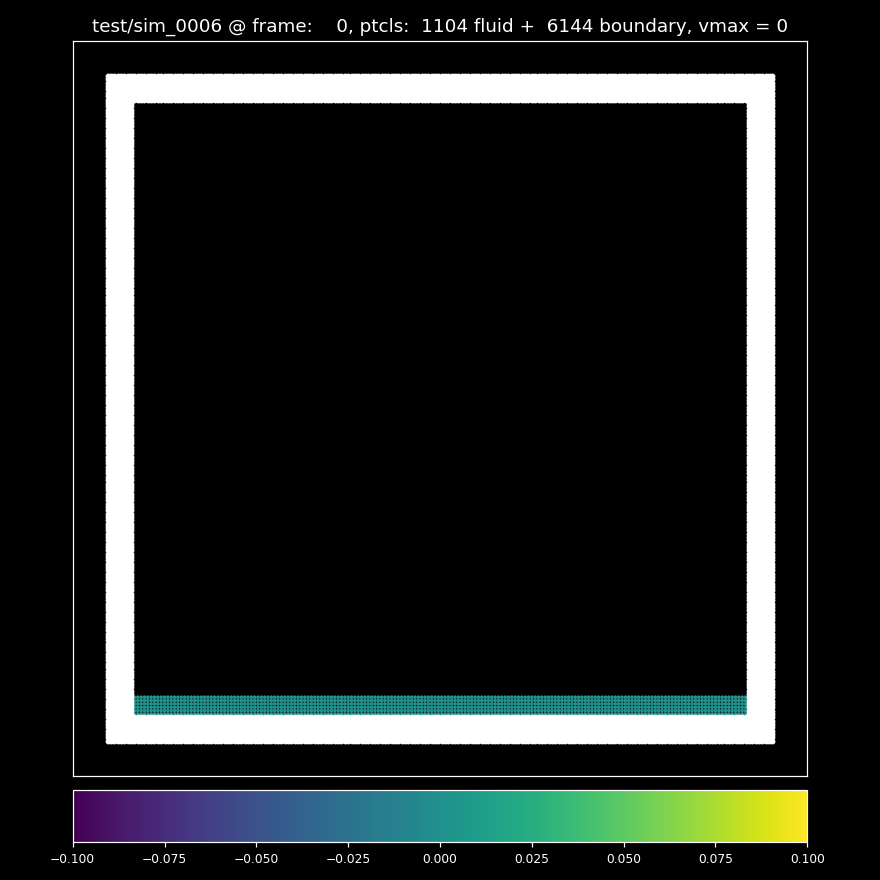

/home/winchenbach/anaconda3/envs/DeepLagrangianFluids/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(Dropdown(description='fileName', options=('test/sim_0006.hdf5', 'test/sim_0024.hdf5', 't…

<function __main__.plotNetwork(fileName, frame)>

In [5]:
fig, axis = plt.subplots(1, 1, figsize=(8,8), sharex = False, sharey = False, squeeze = False)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-0.05,1.05)
axis[0,0].set_ylim(-0.05,1.05)

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1), 1)
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)
GTsc = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
bdyScatter = axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )


ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 
axis[0,0].set_title('%s @ %2d' % (simulationFiles[0].split('/')[-1].split('.')[0], 0))
    
prevFile = None
prevFrame = None
        
axis[0,0].set_xticks([], [])
axis[0,0].set_yticks([], [])
    
frameSlider = widgets.IntSlider(value=0, min=0, max=getFrameCount(simulationFiles[0]) - 1, step=1)

fig.tight_layout()

interact(plotNetwork, fileName = simFiles, frame = frameSlider)




In [6]:
import subprocess
import shlex

def createOutputs(simulationFile):
    file = basePath + '/' + simulationFile
    
    inFile = h5py.File(file, 'r')
    frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
    inFile.close()

    
    imageFolder = '../images/%s/' % simulationFile.split('.')[0].replace('/','_')
#     print(imageFolder)
#     break
    
    if not os.path.exists(imageFolder):
        os.makedirs(imageFolder)
        for i in tqdm(range(0, frameCount, 8), leave = False):
            plotNetwork(simulationFile, i)
            imagePath = '../images/%s/%04d.png' % (simulationFile.split('.')[0].replace('/','_'), i)
            plt.savefig(imagePath, dpi = 200)
#         print('converting to video')
        p = subprocess.Popen(shlex.split("/usr/bin/ffmpeg -y -hide_banner -loglevel error -framerate 50 -f image2 -pattern_type glob -i '*.png' -c:v libx264 -b:v 20M -r 50 out.mp4"), cwd='../images/%s/' % simulationFile.split('.')[0].replace('/','_'))
        p.wait()
#         print('Creating video gif')
        p = subprocess.Popen(shlex.split("/usr/bin/ffmpeg -y -hide_banner -loglevel error -i out.mp4 -filter_complex 'fps=50,scale=720:-1:flags=lanczos,split[s0][s1];[s0]palettegen=max_colors=32[p];[s1][p]paletteuse=dither=bayer' output.gif"), cwd='../images/%s/' % simulationFile.split('.')[0].replace('/','_'))
        p.wait()
#         print('Copying output')
        p = subprocess.Popen(shlex.split('cp output.gif ../%s.gif' % (simulationFile.split('.')[0].replace('/','_')).replace(' ','_')), cwd = '../images/%s/' % simulationFile.split('.')[0].replace('/','_'))
        p.wait()
    else:
        print('nothing to do for %s' % simulationFile)
    return
    

In [7]:
# for s in tqdm(simFiles):
#     createOutputs(s)

In [8]:

def loadRbfModel(file, frame, networkPath, epoch):
    with open(os.path.expanduser("%s/results.json" % networkPath), "r") as read_file:
        decodedArray = json.load(read_file)
        dataDict = decodedArray
    
    n = dataDict['hyperParameters']['n']
    m = dataDict['hyperParameters']['m']
    coordinateMapping = dataDict['hyperParameters']['coordinateMapping']
    windowFn = getWindowFunction(dataDict['hyperParameters']['windowFunction'])
    rbf_x = dataDict['hyperParameters']['rbf_x']
    rbf_y = dataDict['hyperParameters']['rbf_y']
    dist = dataDict['hyperParameters']['frameDistance']
    unroll = dataDict['hyperParameters']['maxRollOut']
    arch = [32, 64, 64, 2]
    arch = [16, 32, 32, 2]
    arch = dataDict['hyperParameters']['arch']
    print(arch)

    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(unroll), dist)
    inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
    
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
    
    model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], layers = arch, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 32, )
#     model.load_state_dict(torch.load(os.path.expanduser('%s/model_%03d.torch' % (networkPath, epoch))))
    model = model.to(device)
    model.train(False)
    return model
def getRbfNetworkParams(fileName, frameIndex):
    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
    inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)    
    return inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device)
def computeRbfNetworkLoss(predictedPosition, predictedVelocity, groundTruth, modelOutput):
    posLoss = torch.sqrt(torch.linalg.norm(groundTruth[:,:2] - predictedPosition, dim = 1))
    return posLoss
    velLoss = torch.sqrt(torch.linalg.norm(groundTruth[:,2:4] - predictedVelocity, dim = 1))
    return posLoss + velLoss    

def runNetwork(initialPosition, initialVelocity, attributes, frameDistance, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, groundTruth, model,fluidBatches, boundaryBatches, li):
    # if verbose:
    #     print('running network with')
    #     print('initialPosition', initialPosition[:4])
    #     print('initialVelocity', initialVelocity[:4])
    #     print('dt', dt)
    #     print('frameDistance', frameDistance)        
    #     print('gravity', gravity[:4])
    #     print('fluidFeatures', fluidFeatures[:4])
    #     print('boundaryPositions', boundaryPositions[:4])
    #     print('boundaryFeatures', boundaryFeatures[:4])
    #     print('fluidBatches', fluidBatches)
    #     print('boundaryBatches', boundaryBatches)
    #     print('li', li)
# Heun's method:
    # vel2 = initialVelocity + frameDistance * attributes['dt'] * gravity
    # pos2 = initialPosition + frameDistance * attributes['dt'] * (initialVelocity + vel2) / 2
# semi implicit euler
    d = (frameDistance) * ((frameDistance) + 1) / 2
    vel2 = initialVelocity + frameDistance * attributes['dt'] * gravity
    pos2 = initialPosition + frameDistance * attributes['dt'] * initialVelocity + d * attributes['dt']**2 * gravity
        
#     print(fluidFeatures.device)
#     print(vel2.device)
        
    fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], vel2, fluidFeatures[:,3:]))
    # if verbose:
    #     print('calling network with' )
    #     print('d', d)
    #     print('vel2', vel2[:4])
    #     print('pos2', pos2[:4])
    #     print('fluidFeatures', fluidFeatures[:4])
    predictions = model(pos2, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, fluidBatches, boundaryBatches)

    predictedVelocity = (pos2 + predictions[:,:2] - initialPosition) / (frameDistance * attributes['dt'])
    predictedPositions = pos2 + predictions[:,:2]

#     if li:
#         loss =  model.li * computeLoss(predictedPositions, predictedVelocity, groundTruth.to(pos2.device), predictions)
#     else:
#         loss =   computeLoss(predictedPositions, predictedVelocity, groundTruth.to(pos2.device), predictions)

#     return loss, predictedPositions, predictedVelocity
    return predictedPositions, predictedVelocity
    


In [9]:
networkPath = './trainingData/cconvlike - n=[ 4, 4] rbf=[linear,linear] map = preserving window = poly6 d =  1 e = 25 distance =  1 - 2023-03-03_13-49-52'
model = loadRbfModel(simulationFiles[0],0, networkPath, 49)

fileName = simulationFiles[0]
frameIndex = 100
    
gravity, fluidFeatures, boundaryPositions, boundaryFeatures = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, frameIndex + np.arange(1))
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
# fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
gt = getGroundTruth(fileName, 10)

predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocities = inputData['fluidVelocity'].to(device)
dt = attributes['dt']
attributes['support'] = attributes['support'] * 4.5

predictedPositions, predictedVelocities = runNetwork(predictedPositions, predictedVelocities, attributes, 1, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, gt, model, None, None, False)

[32, 64, 64, 3]


In [10]:
model.convs[-1].bias
# model.fcs[-1].bias



Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)

<IPython.core.display.Javascript object>


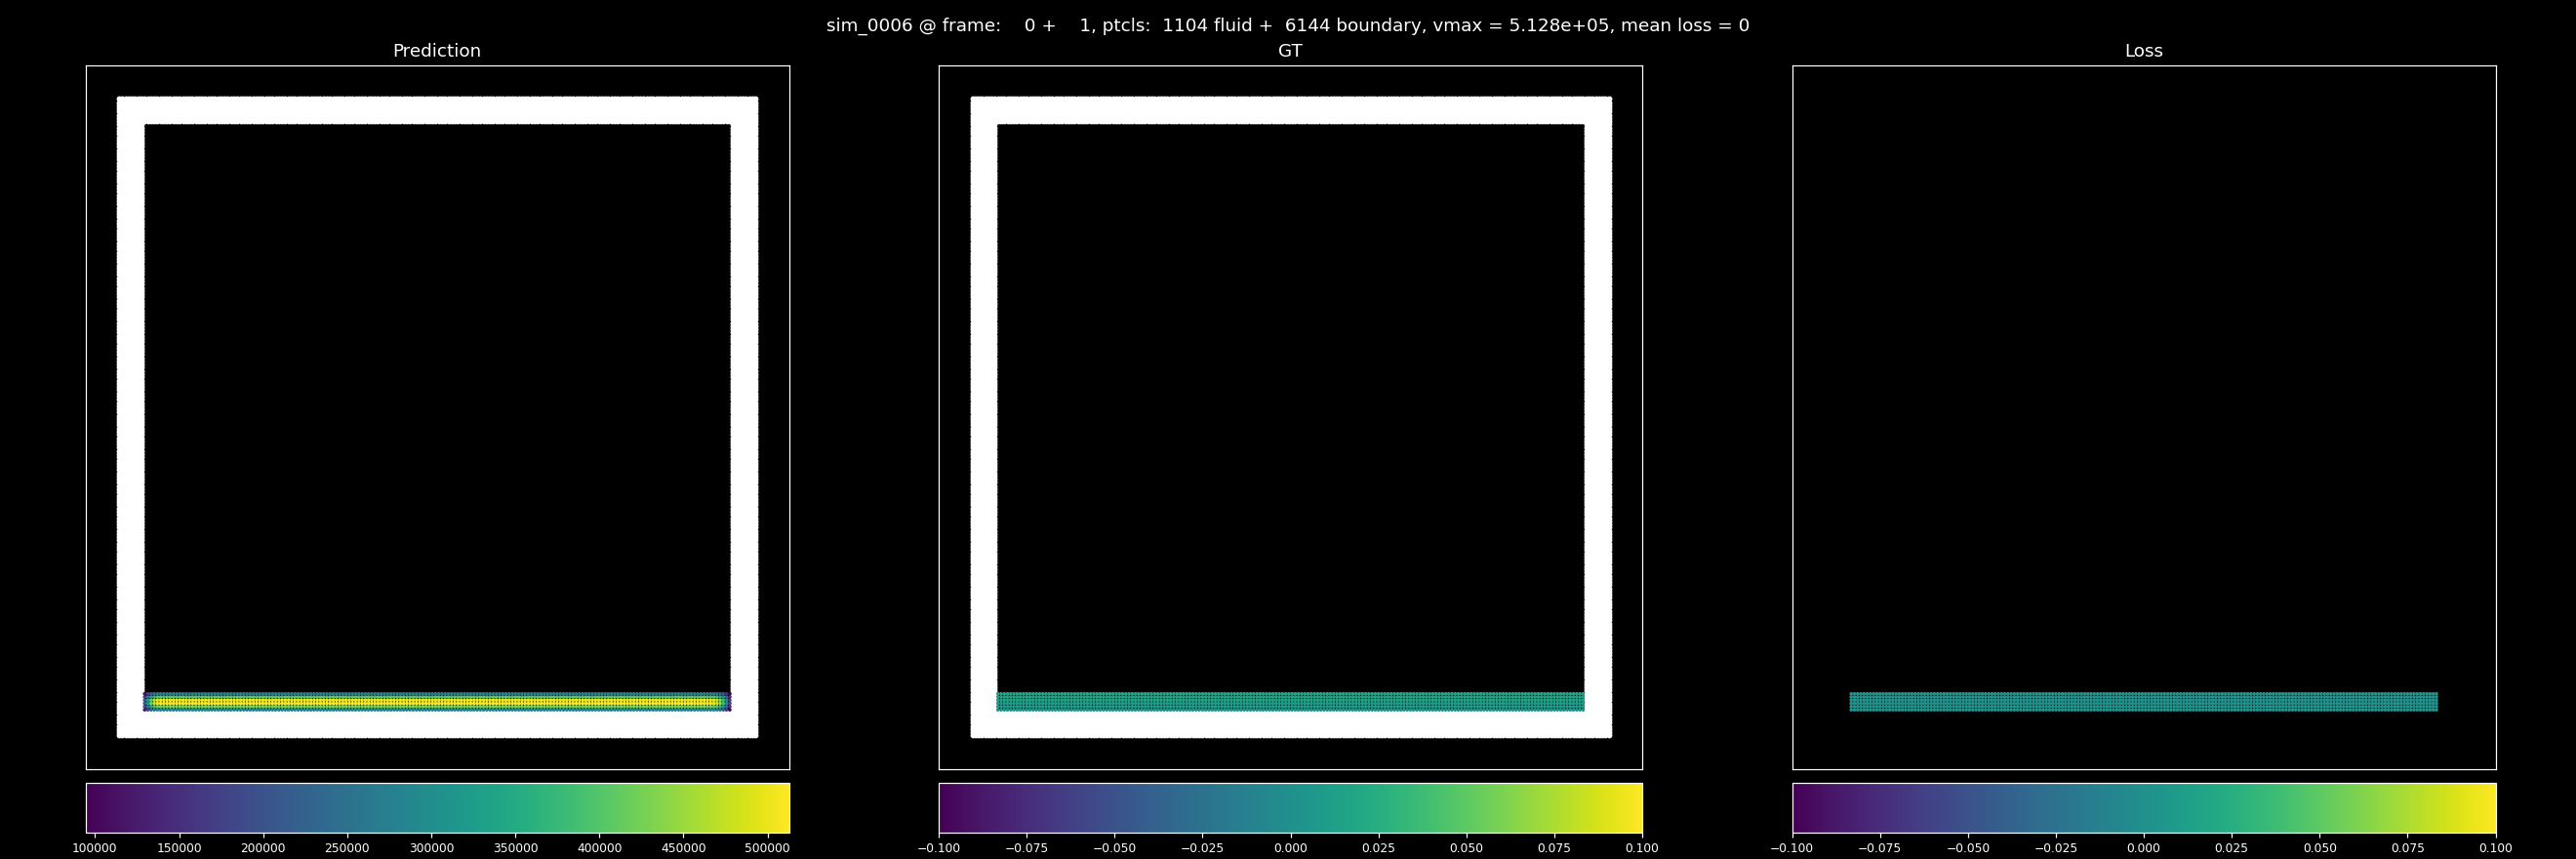

interactive(children=(Dropdown(description='fileName', options=('test/sim_0006.hdf5', 'test/sim_0024.hdf5', 't…

<function __main__.plotNetwork(fileName, frame)>

In [21]:
def plotNetwork(fileName, frame):
    global prevFile, prevFrame   
    
    file = basePath + '/' + fileName
    
    if file != prevFile:
        frameSlider.max = getFrameCount(file) - 1
        frameSlider.value = 0
        frame = 0        
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(0), 1)        
    if file != prevFile:
        bdyScatter0.set_offsets(inputData['boundaryPosition'][:,:2])
        bdyScatter1.set_offsets(inputData['boundaryPosition'][:,:2])
#         bdyScatter2.set_offsets(inputData['boundaryPosition'][:,:2])
        prevFile = file        
    if frame != prevFrame:
        prevFrame = frame
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    sc0.set_offsets(positions)
    sc0.set_array(data)
    cbar0.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    sc1.set_offsets(positions)
    sc1.set_array(data)
    cbar1.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))        
    sc2.set_offsets(positions)
    sc2.set_array(data)
    cbar2.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))        
    
#     axis[0,0].set_title('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.suptitle('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.canvas.draw()
    fig.canvas.flush_events()
   

fig, axis = plt.subplots(1, 3, figsize=(24,8), sharex = False, sharey = False, squeeze = False)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-0.05,1.05)
axis[0,0].set_ylim(-0.05,1.05)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-0.05,1.05)
axis[0,1].set_ylim(-0.05,1.05)
axis[0,2].axis('equal')
axis[0,2].set_xlim(-0.05,1.05)
axis[0,2].set_ylim(-0.05,1.05)

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1), 1)
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)

bdyScatter0 = axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
bdyScatter1 = axis[0,1].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
# bdyScatter2 = axis[0,2].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )

sc0 = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar0 = fig.colorbar(sc0, cax=cax1,orientation='horizontal')
cbar0.ax.tick_params(labelsize=8) 

sc1 = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar1 = fig.colorbar(sc1, cax=cax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=8) 

sc2 = axis[0,2].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar2 = fig.colorbar(sc2, cax=cax1,orientation='horizontal')
cbar2.ax.tick_params(labelsize=8) 

fig.suptitle('%s @ %2d' % (simulationFiles[0].split('/')[-1].split('.')[0], 0))
axis[0,0].set_title('Prediction')
axis[0,1].set_title('GT')
axis[0,2].set_title('Loss')
    
prevFile = None
prevFrame = None
        
axis[0,0].set_xticks([], [])
axis[0,0].set_yticks([], [])
axis[0,1].set_xticks([], [])
axis[0,1].set_yticks([], [])
axis[0,2].set_xticks([], [])
axis[0,2].set_yticks([], [])
    
frameSlider = widgets.IntSlider(value=0, min=0, max=getFrameCount(simulationFiles[0]) - 1, step=1)

fig.tight_layout()

interact(plotNetwork, fileName = simFiles, frame = frameSlider)

In [22]:
# imageFolder = 'cconv(Me)'
# os.makedirs(imageFolder)
# # for i in tqdm(range(0, frameCount, 8), leave = False):
# #     plotNetwork(simulationFile, i)
# imagePath = '%s/%04d.png' % (imageFolder, 0)
# plt.savefig(imagePath, dpi = 200)

In [23]:
attributes['support'] = attributes['support'] / 4 * 4.5

In [33]:
print(prevFile)
print(prevFrame)
fileName = prevFile
frameIndex = prevFrame
    
gravity, fluidFeatures, boundaryPositions, boundaryFeatures = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 0 + np.arange(1))
attributes['support'] = attributes['support'] / 4 * 4.5
# attributes['support'] = 4.5 * attributes['support']
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
# fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
gt = getGroundTruth(fileName, 10)

predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocities = inputData['fluidVelocity'].to(device)
dt = attributes['dt']
attributes['support'] = attributes['support'] * 4.


for i in range(1, 2):
    gt = getGroundTruth(fileName, prevFrame + i)
    predictedPositions, predictedVelocities, = runNetwork(predictedPositions, predictedVelocities, attributes, 1, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, gt, model, None, None, False)
    
    data = np.linalg.norm(predictedVelocities.detach().cpu().numpy(),axis=1)    
#     sc0.set_offsets(predictedPositions.detach().cpu().numpy())
    sc0.set_array(data)
    cbar0.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    
    gtdata = np.linalg.norm(gt[1].detach().cpu().numpy(), axis = 1)
    sc1.set_offsets(gt[0].detach().cpu().numpy())
    sc1.set_array(gtdata)
    sc2.set_offsets(gt[0].detach().cpu().numpy())
#     sc2.set_array(loss.detach().cpu().numpy())
    
    fig.suptitle('%s @ frame: %4d + %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g, mean loss = %.4g' % (prevFile.split('/')[-1].split('.')[0], prevFrame, i, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data), 0))
    fig.canvas.draw()
    fig.canvas.flush_events()
    


/home/winchenbach/dev/datasets/WBCSPH2Dc/test/sim_0006.hdf5
0
torch.return_types.max(
values=tensor([885.9565, 926.5616, 916.0222], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([380, 380, 380], device='cuda:0'))


In [32]:

def runNetwork(initialPosition, initialVelocity, attributes, frameDistance, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, groundTruth, model,fluidBatches, boundaryBatches, li):
    # if verbose:
    #     print('running network with')
    #     print('initialPosition', initialPosition[:4])
    #     print('initialVelocity', initialVelocity[:4])
    #     print('dt', dt)
    #     print('frameDistance', frameDistance)        
    #     print('gravity', gravity[:4])
    #     print('fluidFeatures', fluidFeatures[:4])
    #     print('boundaryPositions', boundaryPositions[:4])
    #     print('boundaryFeatures', boundaryFeatures[:4])
    #     print('fluidBatches', fluidBatches)
    #     print('boundaryBatches', boundaryBatches)
    #     print('li', li)
# Heun's method:
    # vel2 = initialVelocity + frameDistance * attributes['dt'] * gravity
    # pos2 = initialPosition + frameDistance * attributes['dt'] * (initialVelocity + vel2) / 2
# semi implicit euler
    d = (frameDistance) * ((frameDistance) + 1) / 2
    vel2 = initialVelocity + frameDistance * attributes['dt'] * gravity
    pos2 = initialPosition + frameDistance * attributes['dt'] * initialVelocity + d * attributes['dt']**2 * gravity
        
#     print(fluidFeatures.device)
#     print(vel2.device)
        
    fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], vel2, fluidFeatures[:,3:]))
    # if verbose:
    #     print('calling network with' )
    #     print('d', d)
    #     print('vel2', vel2[:4])
    #     print('pos2', pos2[:4])
    #     print('fluidFeatures', fluidFeatures[:4])
    predictions = model(pos2, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, fluidBatches, boundaryBatches) * 128 * 1e-6
    print(torch.max(predictions, dim = 0))

    predictedVelocity = (pos2 + predictions[:,:2] - initialPosition) / (frameDistance * attributes['dt'])
    predictedPositions = pos2 + predictions[:,:2]

#     if li:
#         loss =  model.li * computeLoss(predictedPositions, predictedVelocity, groundTruth.to(pos2.device), predictions)
#     else:
#         loss =   computeLoss(predictedPositions, predictedVelocity, groundTruth.to(pos2.device), predictions)

#     return loss, predictedPositions, predictedVelocity
    return predictedPositions, predictedVelocity


In [27]:
print(torch.max(predictedPositions, dim = 0))

torch.return_types.max(
values=tensor([6921535.5000, 7238762.5000], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([380, 380], device='cuda:0'))


In [13]:
print(prevFile)
print(prevFrame)
fileName = prevFile
frameIndex = prevFrame
    
gravity, fluidFeatures, boundaryPositions, boundaryFeatures = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 0 + np.arange(1))
attributes['support'] = 4.5 * attributes['support']
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
# fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
gt = getGroundTruth(fileName, 10)

predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocities = inputData['fluidVelocity'].to(device)
dt = attributes['dt']
# attributes['support'] = attributes['support'] * 4.


predictedPositions, predictedVelocities, = runNetwork(predictedPositions, predictedVelocities, attributes, 1, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, gt, model, None, None, False)
predictedPositions, predictedVelocities, = runNetwork(predictedPositions, predictedVelocities, attributes, 1, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, gt, model, None, None, False)

/home/winchenbach/dev/datasets/WBCSPH2Dc/test/sim_0006.hdf5
0


In [14]:
torch.max(model.ni)

tensor(6, device='cuda:0')

In [15]:
print(torch.min(predictedPositions, dim = 0))

torch.return_types.min(
values=tensor([117183.9375, 121734.5859], device='cuda:0', grad_fn=<MinBackward0>),
indices=tensor([1103, 1103], device='cuda:0'))
